In [1]:
%load_ext autoreload
%autoreload 2

# ESM1.6 Scaling

End-to-end pipeline generating scaling plots for [ESM1.6 Pre-industrial configuration](https://github.com/ACCESS-NRI/access-esm1.6-configs/tree/dev-preindustrial%2Bconcentrations).

## Setup
The following variables control where the configurations and model run outputs are saved.

In [ ]:
import os
import getpass

from pathlib import Path

username = getpass.getuser()
defaultproject = os.environ.get("PROJECT")

# Name of the experiment
model_type = "access-esm1.6"
test_path = f"{model_type}_scaling_layouts"
repository_directory = f"{model_type}-PI-config"
config_yaml_name=f"{test_path}/{model_type}_layout_input_config.yaml"

# Whether to only use the best runs from each node setup -> only makes sense
# after the experiments have already been run, and the best performing runs
# have been identified (externally to this notebook at the moment)
use_best_runs = True


In [3]:
# Create profiling manager
from access.profiling import ESM16Profiling
esm_profiling = ESM16Profiling(Path(test_path))

## Generate experiments

We will perform a simple scaling study, varying the total number of nodes used over `[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]`. We will search for different layouts that closely match a scaled 4-node releaed PI config. 

In [4]:
def get_node_configs():
    from access.config.esm1p6_layout_input import LayoutSearchConfig

    num_nodes_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]
    tol_around_ctrl_ratio = [0.05]*len(num_nodes_list)
    max_wasted_ncores_frac=[0.1 if x <= 1 else 0.05 if x <=3 else 0.02 for x in num_nodes_list]
    scaling_configs = [LayoutSearchConfig(tol_around_ctrl_ratio=t, max_wasted_ncores_frac=m) for t, m in zip(tol_around_ctrl_ratio, max_wasted_ncores_frac)]

    return num_nodes_list, scaling_configs

In [5]:

def generate_esm1p6_layouts() -> str:
    import sys

    from access.config.esm1p6_layout_input import generate_esm1p6_core_layouts_from_node_count, generate_esm1p6_perturb_block

    control_expriment_name = "Control_Experiment"
    generator_config_prefix = f"""
model_type: {model_type}
repository_url: git@github.com:ACCESS-NRI/{model_type}-configs.git
start_point: 1ebd393 # the commit hash that access-bot refers to when committing the new checksums

test_path: {test_path}
repository_directory: {repository_directory}

control_branch_name: ctrl

{control_expriment_name}:
    config.yaml:
        walltime: Inf
        modules:
            use:
                - /g/data/{defaultproject}/{username}/spack/0.22/release/modules/linux-rocky8-x86_64_v4
            load:
                - access-esm1p6/2025.09.002

        manifest:
            reproduce:
                exe: False    # cice5 has to be manually compiled because the runtime core counts is set at compile time
        repeat: True
        runspersub: 10

Perturbation_Experiment:
"""

    blocknum = 1
    queue = "normalsr"
    branch_name_prefix = "esm1p6-layout"
    entire_block = generator_config_prefix
    num_nodes_list, scaling_configs = get_node_configs()
    # num_nodes_list = [4.0]
    # from access.config.esm1p6_layout_input import LayoutSearchConfig
    # scaling_configs = [LayoutSearchConfig(tol_around_ctrl_ratio=None, max_wasted_ncores_frac=0.02)]*len(num_nodes_list)

    seen_layouts = set()
    walltime_hrs = 0.0
    for num_nodes, config in zip(num_nodes_list, scaling_configs, strict=True):
        layout = generate_esm1p6_core_layouts_from_node_count(
            num_nodes,
            queue=queue,
            layout_search_config=config,
        )[0]
        if not layout:
            print(f"No layouts found for {num_nodes} nodes", file=sys.stderr)
            continue

        layout = [x for x in layout if x not in seen_layouts]
        seen_layouts.update(layout)
        print(f"Generated {len(layout)} layouts for {num_nodes} nodes. Layouts: {layout}")

        branch_name = f"{branch_name_prefix}-unused-cores-to-cice-{config.allocate_unused_cores_to_ice}"
        prev_blocknum = blocknum
        block, blocknum = generate_esm1p6_perturb_block(
            num_nodes, layout, branch_name, queue=queue, start_blocknum=blocknum,
        )
        nblocks_added = blocknum - prev_blocknum
        walltime_hrs += nblocks_added * (1.5 * 4.0/num_nodes) # use a 1.5 hrs time for 4-node runs, and then scale linearly
        entire_block += block

    entire_block = entire_block.replace("walltime: Inf", f"walltime: {int(walltime_hrs)}:00:00")

    return entire_block

## Generate the config and write into a file


In [6]:
# Generate the configuration and write to file
generator_config = generate_esm1p6_layouts()

with open(config_yaml_name, "w") as f:
    f.write(generator_config)
print(f"Generator config written to {config_yaml_name}")

Min. total cores required for a valid config (94) should be greater than the number of ATM + OCN cores (101). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores
Min. total cores required for a valid config (198) should be greater than the number of ATM + OCN cores (202). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores
Min. total cores required for a valid config (297) should be greater than the number of ATM + OCN cores (303). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores


Generated 2 layouts for 1.0 nodes. Layouts: [LayoutTuple(atm_nx=8, atm_ny=6, mom_nx=8, mom_ny=6, ice_ncores=3), LayoutTuple(atm_nx=8, atm_ny=6, mom_nx=9, mom_ny=5, ice_ncores=3)]
Generated 4 layouts for 2.0 nodes. Layouts: [LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=10, mom_ny=10, ice_ncores=6), LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=11, mom_ny=9, ice_ncores=6), LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=12, mom_ny=8, ice_ncores=6), LayoutTuple(atm_nx=12, atm_ny=8, mom_nx=12, mom_ny=8, ice_ncores=6)]
Generated 3 layouts for 3.0 nodes. Layouts: [LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=12, mom_ny=12, ice_ncores=9), LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=13, mom_ny=11, ice_ncores=9), LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=14, mom_ny=10, ice_ncores=9)]
Generated 3 layouts for 4.0 nodes. Layouts: [LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=14, mom_ny=14, ice_ncores=12), LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=15, mom_ny=13, ice_ncores=12), LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=16, mom_

In [ ]:
from experiment_generator.experiment_generator import ExperimentGenerator
from ruamel.yaml import YAML

ryaml = YAML()
ryaml.preserve_quotes = True

config_dict = ryaml.load(generator_config)

expgen = ExperimentGenerator(config_dict)
expgen.run()

-- Test directory access-esm1.6_scaling_layouts already exists!
-- Test dir: /home/593/ms2335/codes/access-nri/scaling_studies/access-models-scaling/access-esm1.6_scaling_layouts/access-esm1.6-PI-config already exists, hence not cloning git@github.com:ACCESS-NRI/access-esm1.6-configs.git
Checked out branch: ctrl
laboratory path:  /scratch/tm70/ms2335/access-esm
binary path:  /scratch/tm70/ms2335/access-esm/bin
input path:  /scratch/tm70/ms2335/access-esm/input
work path:  /scratch/tm70/ms2335/access-esm/work
archive path:  /scratch/tm70/ms2335/access-esm/archive
Found experiment archive: /scratch/tm70/ms2335/access-esm/archive/access-esm1.6-PI-config-ctrl-22561c0f
Removed archive symlink to /scratch/tm70/ms2335/access-esm/archive/access-esm1.6-PI-config-esm1p6-layout-unused-cores-to-cice-False_atm_22x18_mom_22x18_ice_24x1-0b1c540a
Added archive symlink to /scratch/tm70/ms2335/access-esm/archive/access-esm1.6-PI-config-ctrl-22561c0f
-- Branch esm1p6-layout-unused-cores-to-cice-False_atm

## Generating the list of experiments to run or analyse

Next get a list of all the new/existing branches and register them

In [ ]:
if use_best_runs:
    pe_expts = config_dict["Perturbation_Experiment"]
    all_branches = [x for k in pe_expts for x in pe_expts[k]["branches"]]
else:
    print("Skipping running experiments.")
    all_branches = ['esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_16x13_mom_15x13_ice_12x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_16x16_mom_16x15_ice_15x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_18x17_mom_18x16_ice_18x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_20x20_mom_22x18_ice_24x1']

esm_profiling.generate_experiments(all_branches)

In [ ]:
esm_profiling.nruns = 3 # Each run is repeated three times.
esm_profiling.run_experiments()

* Current Branch: esm1p6-layout-unused-cores-to-cice-False_atm_22x18_mom_22x18_ice_24x1
    experiment_uuid: 0b1c540a-a2cb-4a43-b481-8b23f52d0187
Branch: ctrl
    experiment_uuid: 22561c0f-72b4-4024-b385-a772e2c8301c
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1
    experiment_uuid: ff836dde-8c4d-418a-b840-54748272d2cf
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_11x9_ice_6x1
    experiment_uuid: 9d76384a-079b-4cc6-9f4f-870bdb681bcb
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_12x8_ice_6x1
    experiment_uuid: 63d98ee2-ec3a-4052-b5ca-b8295c0b2a13
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_12x8_mom_12x8_ice_6x1
    experiment_uuid: 09472374-4db6-403b-93f4-093f7dc4934f
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1
    experiment_uuid: b100d15b-a3f9-45f2-b0d8-0f656d265c13
Branch: esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_13x11_ice_9x1
    experiment_uuid: 1845950c-c3f2-

## Parsing and plotting experiment results


In [10]:
esm_profiling.parse_scaling_data()

Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1/config! Using the first one found.
Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1/config! Using the first one found.
Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1/config! Using the first one f

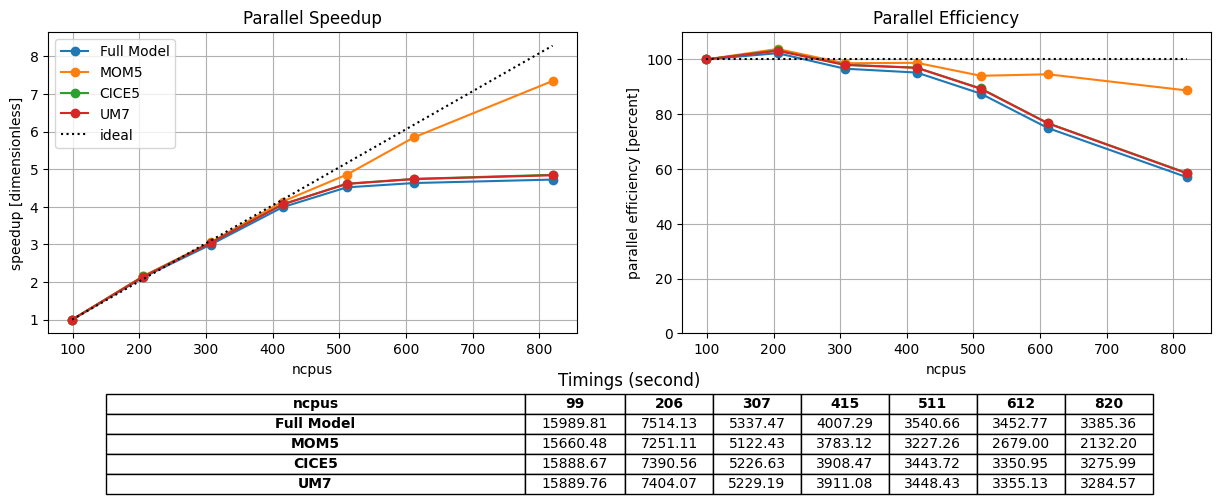

In [14]:
from access.profiling.metrics import tmax

fig = esm_profiling.plot_scaling_data(
    components=["payu", "MOM5", "CICE5", "UM_Total_Walltime"],
    regions=[
        ["payu_model_run_duration_seconds"],
        ["Ocean"],
        ["Total"],
        ["um_total_walltime"],
    ],
    metric=tmax,
    region_relabel_map={
        "payu_model_run_duration_seconds": "Full Model",
        "Ocean": "MOM5",
        "Total": "CICE5",
        "um_total_walltime": "UM7",
        "ncpus": "Number of Cores",
    }
)

## Summary

We have presented the strong scaling results from the [`preindustrial-concentrations` configuration](https://github.com/ACCESS-NRI/access-esm1.6-configs/tree/dev-preindustrial%2Bconcentrations) within ESM 1.6, using the [`2025.09.002 release`](https://github.com/ACCESS-NRI/ACCESS-ESM1.6/releases/tag/2025.09.002) of ACCESS-ESM 1.6. The underlying components are UM7.3 for atmosphere, MOM5 for ocean, and CICE5 for the ice models. These three components run concurrently over the course of the experiment, with the atmosphere and ice cores responsible for exchanging data (i.e., MPI operations between all three components). The released configuration for ESM1.6 uses 4-nodes on the normalsr queue with sapphirerapids cpus, where each node contains 104 cores.

We have varied the number of nodes between 1 and 8, and for each case, we have tested several options with different partitioning of the total number of available cores between the three components. In the plots above, we have presented the best performing configuration for each case. For the two top plots, the x-axis is `ncpus` which represents the total number of cores used in the configuration, and the y-axis is speedup relative to the single node config (left) and computational efficiency relative to the single node config (right). The plot on the left shows that the ESM1.6 model shows near-ideal scaling up to 4 nodes, and then performance drops off and plateaus for higher node-counts. We observe a similar effect in the computational efficiency as well - the efficiency is above 90% for all nodes up to 4, but then drops off for higher node counts. Due to the concurrent running of the three components, we expect that this drop-off is partially from imperfect loadbalancing, and further investigation is required to improve the scaling for running ESM1.6 on >= 5 nodes. The table shows the raw data from the runs corresponding to each of the components, and the overall model runtime. The columns represent 1, 2, 3, 4, 5, 6, and 8 node configs.
